# Analyzing the logs

In [1]:
# Run from the top of the repository
%cd ..

/Users/pete/calkit/boom-paper


In [2]:
import pandas as pd
import polars as pl
import yaml
import itertools
import os

with open("calkit.yaml") as f:
    calkit_config = yaml.safe_load(f)

# Load the BOOM and Kowalski configurations
boom_params = {}
for i in calkit_config["pipeline"]["stages"]["benchmark-boom"]["iterate_over"]:
    boom_params[i["arg_name"]] = i["values"]

kowalski_params = {}
for i in calkit_config["pipeline"]["stages"]["benchmark-kowalski"][
    "iterate_over"
]:
    kowalski_params[i["arg_name"]] = i["values"]

# Form the matrix of parameters for each
param_names = list(boom_params.keys())
param_vals = list(boom_params.values())
vals_product = list(itertools.product(*param_vals))
for i in calkit_config["pipeline"]["stages"]["benchmark-boom-more"][
    "iterate_over"
][0]["values"]:
    vals_product.append(tuple(i))
results_boom = []

for vals in vals_product:
    current_params = dict(zip(param_names, vals))
    boom_config = (
        f"na={current_params['n_alert_workers']}-"
        f"nml={current_params['n_ml_workers']}-"
        f"nf={current_params['n_filter_workers']}"
    )
    boom_consumer_log_fpath = f"logs/boom-{boom_config}/consumer.log"
    boom_scheduler_log_fpath = f"logs/boom-{boom_config}/scheduler.log"
    # To calculate BOOM wall time, take first timestamp from the consumer log
    # as the start and the last timestamp of the scheduler as the end
    if not os.path.isfile(boom_consumer_log_fpath):
        print(f"WARNING: {boom_consumer_log_fpath} does not exist")
        continue
    with open(boom_consumer_log_fpath) as f:
        line = f.readline()
        t1_b = pd.to_datetime(
            line.split()[2].replace("\x1b[2m", "").replace("\x1b[0m", "")
        )
    with open(boom_scheduler_log_fpath) as f:
        lines = f.readlines()
        line = lines[-3]
        t2_b = pd.to_datetime(
            line.split()[2].replace("\x1b[2m", "").replace("\x1b[0m", "")
        )
    current_params["start_time"] = t1_b
    current_params["end_time"] = t2_b
    boom_wall_time = t2_b - t1_b
    results_boom.append(current_params)

df_boom = pl.DataFrame(results_boom).with_columns(
    (pl.col("end_time") - pl.col("start_time"))
    .dt.total_seconds()
    .alias("wall_time_s")
)

# Kowalski only has one parameter name, so we don't need the product
param_name = list(kowalski_params.keys())[0]
param_vals = kowalski_params[param_name]
results_kowalski = []

for val in param_vals:
    res = {param_name: val}
    kowalski_config = f"n={val}"
    log_fpath = f"logs/kowalski-{kowalski_config}/supervisord.log"
    if not os.path.isfile(log_fpath):
        print(f"WARNING: {log_fpath} does not exist")
        continue
    # To calculate Kowalski wall time, just use the supervisord logs
    with open(log_fpath) as f:
        lines = f.readlines()
        for line in lines:
            if "alert-broker-ztf entered RUNNING state" in line:
                t1_k = pd.to_datetime("T".join(line.split()[:2]))
                break
        for line in lines:
            if "received SIGTERM indicating exit request" in line:
                t2_k = pd.to_datetime("T".join(line.split()[:2]))
                break
    # Print the total time of each, in minutes
    kowalski_wall_time = t2_k - t1_k  # type: ignore
    res["start_time"] = t1_k
    res["end_time"] = t2_k
    results_kowalski.append(res)

df_kowalski = pl.DataFrame(results_kowalski).with_columns(
    (pl.col("end_time") - pl.col("start_time"))
    .dt.total_seconds()
    .alias("wall_time_s")
)

# Write results to file for later analysis
os.makedirs("results", exist_ok=True)
df_boom.write_csv("results/boom.csv")
df_kowalski.write_csv("results/kowalski.csv")

# Calculate throughput factor from a specific config for each
boom_wall_time = (
    df_boom.filter(
        (pl.col("n_alert_workers") == 3)
        & (pl.col("n_ml_workers") == 3)
        & (pl.col("n_filter_workers") == 1)
    )
    .select("wall_time_s")
    .row(0)[0]
)
kowalski_wall_time = (
    df_kowalski.filter(pl.col("n_workers") == 7)
    .select(pl.col("wall_time_s"))
    .row(0)[0]
)

boom_throughput_factor = kowalski_wall_time / boom_wall_time
print(f"BOOM throughput factor: {boom_throughput_factor:.1f}")

BOOM throughput factor: 8.1


In [3]:
pl.Config.set_tbl_rows(50)
df_boom

n_alert_workers,n_ml_workers,n_filter_workers,start_time,end_time,wall_time_s
i64,i64,i64,"datetime[μs, UTC]","datetime[μs, UTC]",i64
1,3,1,2025-08-08 13:19:55.636663 UTC,2025-08-08 13:23:25.574940 UTC,209
1,3,3,2025-08-08 13:24:02.475603 UTC,2025-08-08 13:27:33.568716 UTC,211
1,6,1,2025-08-08 13:28:08.337359 UTC,2025-08-08 13:31:35.476596 UTC,207
1,6,3,2025-08-08 13:32:10.444863 UTC,2025-08-08 13:35:36.482399 UTC,206
1,9,1,2025-08-08 16:31:02.821176 UTC,2025-08-08 16:34:31.773996 UTC,208
1,9,3,2025-08-08 13:40:16.593760 UTC,2025-08-08 13:43:45.830376 UTC,209
3,3,1,2025-08-08 13:44:21.151332 UTC,2025-08-08 13:45:36.562160 UTC,75
3,3,3,2025-08-08 13:46:08.251864 UTC,2025-08-08 13:47:25.196085 UTC,76
3,6,1,2025-08-08 13:47:55.644193 UTC,2025-08-08 13:49:07.049585 UTC,71


In [4]:
df_kowalski

n_workers,start_time,end_time,wall_time_s
i64,datetime[μs],datetime[μs],i64
3,2025-08-08 14:03:53,2025-08-08 14:26:23,1350
6,2025-08-08 14:26:58,2025-08-08 14:38:32,694
7,2025-08-08 15:40:59,2025-08-08 15:51:10,611
9,2025-08-08 14:49:48,2025-08-08 14:57:57,489
12,2025-08-08 14:58:31,2025-08-08 15:05:00,389
15,2025-08-08 15:05:34,2025-08-08 15:10:58,324
20,2025-08-12 04:24:08,2025-08-12 04:28:42,274
25,2025-08-12 04:29:21,2025-08-12 04:33:29,248


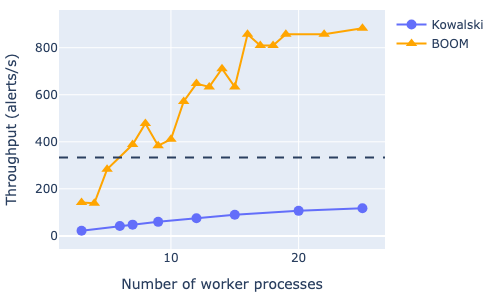

In [5]:
# Plot Kowalski scaling
import os

from IPython.display import Image
import plotly.graph_objects as go

n_alerts = 29140

alerts_per_second = n_alerts / df_kowalski["wall_time_s"]

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df_kowalski["n_workers"],
        y=alerts_per_second,
        mode="markers+lines",
        marker=dict(size=10),
        name="Kowalski",
    )
)
fig.update_layout(
    xaxis_title="Number of worker processes",
    yaxis_title="Throughput (alerts/s)",
    title=None,
)
# Shrink margins
fig.update_layout(margin=dict(t=10, b=10, l=10, r=10))

# Now add BOOM
# For a given worker sum, select the highest normalized throughput, i.e.,
# group by n_workers and select the max throughput
df_boom = df_boom.with_columns(
    n_workers=(
        pl.col("n_alert_workers")
        + pl.col("n_ml_workers")
        + pl.col("n_filter_workers")
    ),
    alerts_per_second=(n_alerts / pl.col("wall_time_s")),
)
df_boom_max = (
    df_boom.group_by("n_workers")
    .agg(max_throughput=pl.col("alerts_per_second").max())
    .sort("n_workers")
)

fig.add_trace(
    go.Scatter(
        x=df_boom_max["n_workers"],
        y=df_boom_max["max_throughput"],
        mode="markers+lines",
        marker=dict(size=10),
        name="BOOM",
        marker_symbol="triangle-up",
        marker_color="orange",
    )
)

rubin_throughput = 10_000 / 30

fig.add_hline(y=rubin_throughput, line=dict(dash="dash"))

os.makedirs("paper/figures", exist_ok=True)
fig.write_image("paper/figures/scaling.png", width=500, height=300)
fig.show()

Image("paper/figures/scaling.png")

In [6]:
# Analyze some of the memory usage
import json
import polars as pl
from typing import Literal

boom_cfg = "na=3-nml=3-nf=3"
kowalski_config = "n=7"

fpath = f"logs/boom-{boom_config}/scheduler.stats.log"


def get_data(
    system: Literal["boom", "kowalski"] = "boom",
    subsystem: Literal["scheduler", "consumer"] | None = None,
):
    fpath = f"logs/{system}-"
    if system == "boom":
        fpath += boom_cfg + f"/{subsystem}.stats.log"
    else:
        fpath += kowalski_config + "/ingester.stats.log"
    with open(fpath) as f:
        txt = f.read()
    txt = (
        txt.replace("\x1b[H", "")
        .replace("\x1b[K", "")
        .replace("\x1b[J", "")
        .split("\n")
    )
    data = []
    for row in txt:
        try:
            d = json.loads(row)
        except Exception:
            pass
        mem = d["MemUsage"].split(" / ")[0]
        if "KiB" in mem:
            mem = float(mem.split("KiB")[0]) / 1e3
        elif "MiB" in mem:
            mem = float(mem.split("MiB")[0])
        elif "GiB" in mem:
            mem = float(mem.split("GiB")[0]) * 1e3
        elif mem == "0B":
            mem = 0.0
        d["mem_mb"] = mem
        data.append(d)
    df = pl.DataFrame(data)
    return df


df_boom_consumer = get_data("boom", "consumer")
df_boom_scheduler = get_data("boom", "scheduler")
df_boom = df_boom_consumer + df_boom_scheduler
df_kowalski = get_data("kowalski", None)

boom_consumer_max_mem = df_boom_consumer["mem_mb"].max()
boom_scheduler_max_mem = df_boom_scheduler["mem_mb"].max()
boom_max_mem = df_boom["mem_mb"].max()
kowalski_max_mem = df_kowalski["mem_mb"].max()

print("BOOM consumer max memory (MB):", boom_consumer_max_mem)
print("BOOM scheduler max memory (MB):", boom_scheduler_max_mem)
print("BOOM max memory (MB):", boom_max_mem)
print("Kowalski max memory (MB):", kowalski_max_mem)

BOOM consumer max memory (MB): 115.4
BOOM scheduler max memory (MB): 775.3
BOOM max memory (MB): 846.14
Kowalski max memory (MB): 12320.0


In [7]:
# TODO: Put actual results here
kafka_ingest_strate_mbps = "XXXXX"
kafka_ingest_factor = "XXXXX"

template = r"""% This file was automatically generated; edits will be overwritten!
\newcommand{\boomthroughputfactor}{BOOM_THROUGHPUT_FACTOR}
\newcommand{\kakfaingestratembps}{KAFKA_INGEST_STRATE_MBPS}
\newcommand{\kakfaingestfactor}{KAFKA_INGEST_FACTOR}
\newcommand{\boommaxmem}{BOOM_MAX_MEM}
\newcommand{\kowalskimaxmem}{KOWALSKI_MAX_MEM}
"""

# This might be better with an f-string, but this is TeX and who wants to deal
# with escaping all the braces?
template = (
    template.replace(
        "BOOM_THROUGHPUT_FACTOR", f"{round(boom_throughput_factor):1d}"
    )
    .replace("KAFKA_INGEST_STRATE_MBPS", kafka_ingest_strate_mbps)
    .replace("KAFKA_INGEST_FACTOR", kafka_ingest_factor)
    .replace("BOOM_MAX_MEM", f"{round(boom_max_mem / 1e3)}")
    .replace("KOWALSKI_MAX_MEM", f"{round(kowalski_max_mem / 1e3)}")
)

with open("paper/results.tex", "w") as f:
    f.write(template)